# Import Library

In [1]:
!pip install kneed

In [2]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer
from kneed import KneeLocator
from sklearn.decomposition import PCA
import plotly.express as px
import os

In [3]:
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bhavikjikadara/retail-transactional-dataset
!unzip retail-transactional-dataset.zip
!ls

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/retail-transactional-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
retail-transactional-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  retail-transactional-dataset.zip
  inflating: retail_data.csv         
kaggle.json  retail_data.csv  retail-transactional-dataset.zip	sample_data


# Data Understanding

## Load dataset, pilih kolom, rename kolom dan ubah menjadi lowercase

In [4]:
df = pd.read_csv('retail_data.csv')
selected_columns = [
    'Customer_ID', 'Transaction_ID', 'Date', 'Order_Status', 'Age',
    'Gender', 'Income', 'Product_Category', 'products', 'Payment_Method',
    'Total_Purchases', 'Amount', 'Total_Amount'
]
df = df[selected_columns].copy()
df = df.rename(columns={
    'Total_Purchases': 'quantity',
    'Amount': 'unit_price',
    'Total_Amount': 'subtotal'
})
df.columns = df.columns.str.lower()
df.head()

customer_id  transaction_id        date order_status   age  gender income  \
0      37249.0       8691788.0   9/18/2023      Shipped  21.0    Male    Low   
1      69749.0       2174773.0  12/31/2023   Processing  19.0  Female    Low   
2      30192.0       6679610.0   4/26/2023   Processing  48.0    Male    Low   
3      62101.0       7232460.0    05-08-23   Processing  56.0    Male   High   
4      27901.0       4983775.0    01-10-24      Shipped  22.0    Male    Low   

  product_category           products payment_method  quantity  unit_price  \
0         Clothing     Cycling shorts     Debit Card       3.0  108.028757   
1      Electronics         Lenovo Tab    Credit Card       2.0  403.353907   
2            Books   Sports equipment    Credit Card       3.0  354.477600   
3       Home Decor      Utility knife         PayPal       7.0  352.407717   
4          Grocery  Chocolate cookies           Cash       2.0  124.276524   

      subtotal  
0   324.086270  
1   806.707815  
2  1063.432799  
3  2466.854021  
4   248.553049

In [5]:
df.shape

(302010, 13)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302010 entries, 0 to 302009
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   customer_id       301702 non-null  float64
 1   transaction_id    301677 non-null  float64
 2   date              301651 non-null  object 
 3   order_status      301775 non-null  object 
 4   age               301837 non-null  float64
 5   gender            301693 non-null  object 
 6   income            301720 non-null  object 
 7   product_category  301727 non-null  object 
 8   products          302010 non-null  object 
 9   payment_method    301713 non-null  object 
 10  quantity          301649 non-null  float64
 11  unit_price        301653 non-null  float64
 12  subtotal          301660 non-null  float64
dtypes: float64(6), object(7)
memory usage: 30.0+ MB


In [7]:
df.describe()

customer_id  transaction_id            age       quantity  \
count  301702.000000    3.016770e+05  301837.000000  301649.000000   
mean    55006.553934    5.495823e+06      35.481326       5.359729   
std     26005.675200    2.595565e+06      15.021933       2.868575   
min     10000.000000    1.000007e+06      18.000000       1.000000   
25%     32469.250000    3.247930e+06      22.000000       3.000000   
50%     55012.000000    5.499657e+06      32.000000       5.000000   
75%     77511.000000    7.739509e+06      46.000000       8.000000   
max     99999.000000    9.999995e+06      70.000000      10.000000   

          unit_price       subtotal  
count  301653.000000  301660.000000  
mean      255.163659    1367.651156  
std       141.389640    1128.998515  
min        10.000219      10.003750  
25%       132.890764     438.724278  
50%       255.470969    1041.117547  
75%       377.672606    2029.999853  
max       499.997911    4999.625796

In [8]:
df.isna().sum()

customer_id         308
transaction_id      333
date                359
order_status        235
age                 173
gender              317
income              290
product_category    283
products              0
payment_method      297
quantity            361
unit_price          357
subtotal            350
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(25)

## Outlier

In [10]:
num_cols = ['age', 'quantity', 'unit_price', 'subtotal']
cat_cols = ['order_status', 'gender', 'income', 'product_category', 'products', 'payment_method']

# Ambang batas z-score (biasanya 3)
threshold = 3

# Hitung Z-score hanya untuk kolom numerik
z_scores = np.abs(stats.zscore(df[num_cols]))

# Buat mask/filter dimana z_score > 3
outliers_mask = (z_scores > threshold)

# Hitung jumlah outlier per kolom
outlier_counts = pd.DataFrame(outliers_mask, columns=num_cols).sum()
print(f"Jumlah Outlier terdeteksi (Threshold > {threshold}):")
print(outlier_counts)

Jumlah Outlier terdeteksi (Threshold > 3):
age           0
quantity      0
unit_price    0
subtotal      0
dtype: int64


## Konversi format tanggal biar seragam

In [11]:
df['date'] = pd.to_datetime(df['date'], dayfirst=False, errors='coerce')

# Cek apakah ada data tanggal yang gagal dikonversi (NaT)
invalid_dates = df['date'].isna().sum()
if invalid_dates > 0:
    print(f"Peringatan: Ada {invalid_dates} baris dengan format tanggal yang salah dan telah dihapus.")
    df.dropna(subset=['date'], inplace=True)
else:
    print("Semua tanggal berhasil dikonversi dengan sukses.")

print(f"\nTipe data kolom Date sekarang: {df['date'].dtype}")
print(df['date'].head(10))

Peringatan: Ada 119115 baris dengan format tanggal yang salah dan telah dihapus.

Tipe data kolom Date sekarang: datetime64[ns]
0    2023-09-18
1    2023-12-31
2    2023-04-26
5    2023-09-21
6    2023-06-26
7    2023-03-24
10   2023-07-20
11   2023-06-21
14   2023-11-18
15   2023-06-15
Name: date, dtype: datetime64[ns]


# EDA

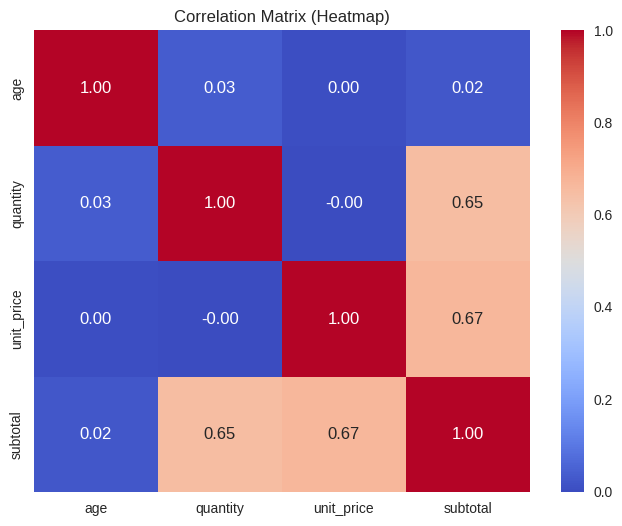

In [12]:
plt.figure(figsize=(8, 6))
valid_cols = [c for c in num_cols if c in df.columns]
sns.heatmap(df[valid_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix (Heatmap)')
plt.show()

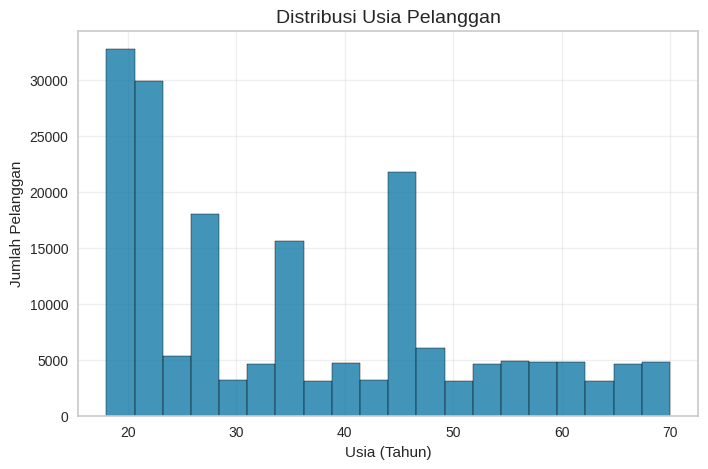

In [13]:
plt.figure(figsize=(8,5))
sns.histplot(df['age'], bins=20)
plt.title('Distribusi Usia Pelanggan', fontsize=14)
plt.xlabel('Usia (Tahun)')
plt.ylabel('Jumlah Pelanggan')
plt.grid(alpha=0.3)
plt.show()

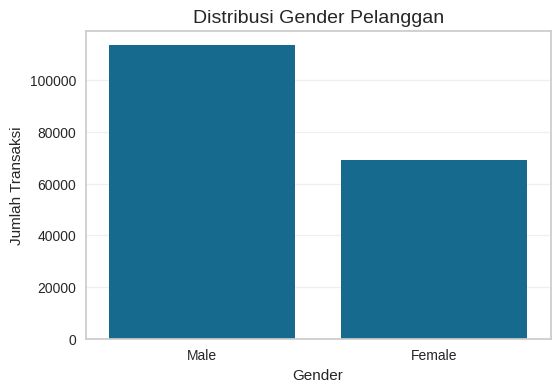

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title('Distribusi Gender Pelanggan', fontsize=14)
plt.xlabel('Gender')
plt.ylabel('Jumlah Transaksi')
plt.grid(axis='y', alpha=0.3)
plt.show()

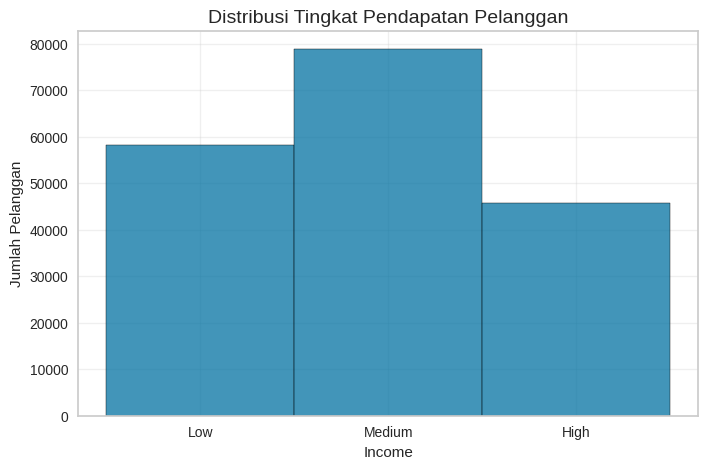

In [15]:
plt.figure(figsize=(8,5))
sns.histplot(df['income'], bins=25)
plt.title('Distribusi Tingkat Pendapatan Pelanggan', fontsize=14)
plt.xlabel('Income')
plt.ylabel('Jumlah Pelanggan')
plt.grid(alpha=0.3)
plt.show()

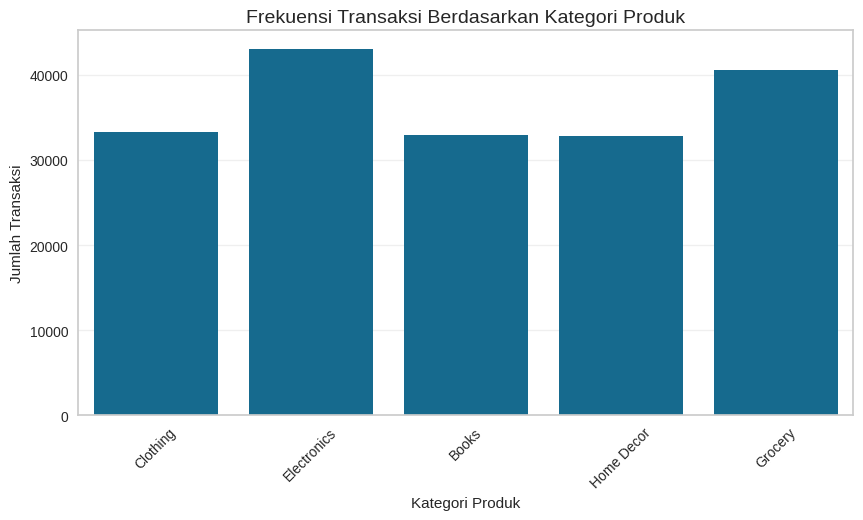

In [16]:
plt.figure(figsize=(10,5))
sns.countplot(x='product_category', data=df)
plt.title('Frekuensi Transaksi Berdasarkan Kategori Produk', fontsize=14)
plt.xlabel('Kategori Produk')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

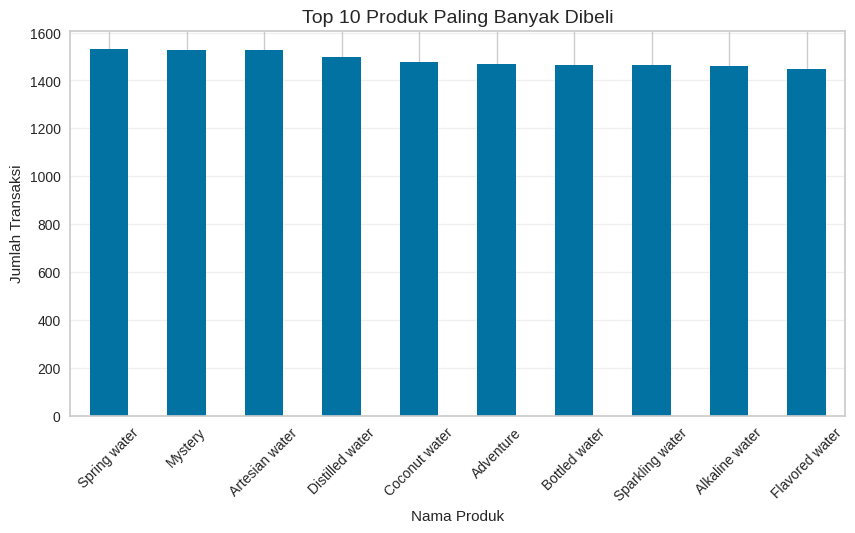

In [17]:
plt.figure(figsize=(10,5))
df['products'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Produk Paling Banyak Dibeli', fontsize=14)
plt.xlabel('Nama Produk')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

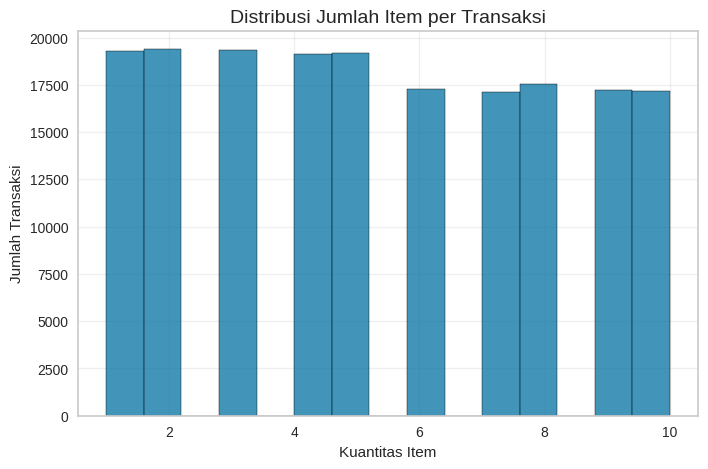

In [18]:
plt.figure(figsize=(8,5))
sns.histplot(df['quantity'], bins=15)
plt.title('Distribusi Jumlah Item per Transaksi', fontsize=14)
plt.xlabel('Kuantitas Item')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
plt.show()

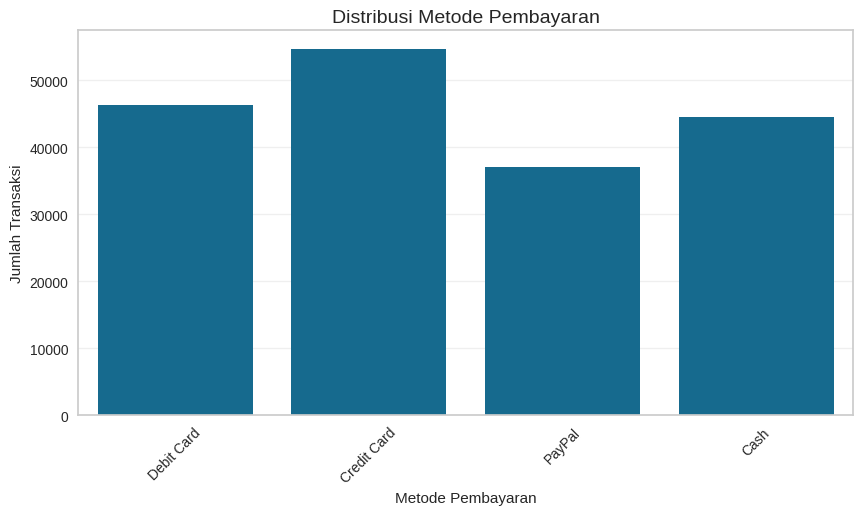

In [19]:
plt.figure(figsize=(10,5))
sns.countplot(x='payment_method', data=df)
plt.title('Distribusi Metode Pembayaran', fontsize=14)
plt.xlabel('Metode Pembayaran')
plt.ylabel('Jumlah Transaksi')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.show()

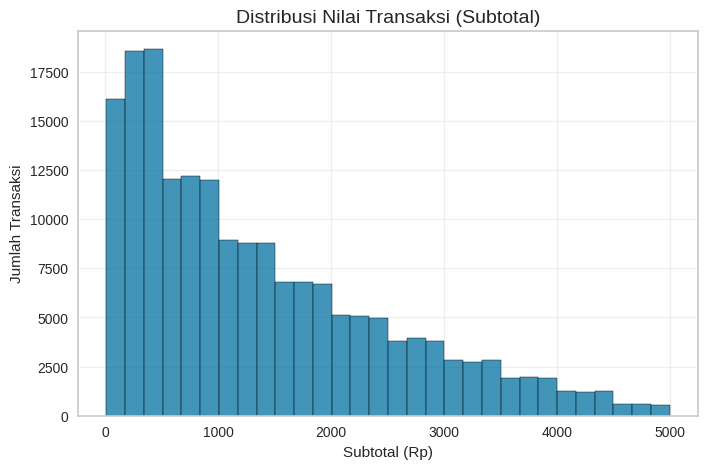

In [20]:
plt.figure(figsize=(8,5))
sns.histplot(df['subtotal'], bins=30)
plt.title('Distribusi Nilai Transaksi (Subtotal)', fontsize=14)
plt.xlabel('Subtotal (Rp)')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
plt.show()

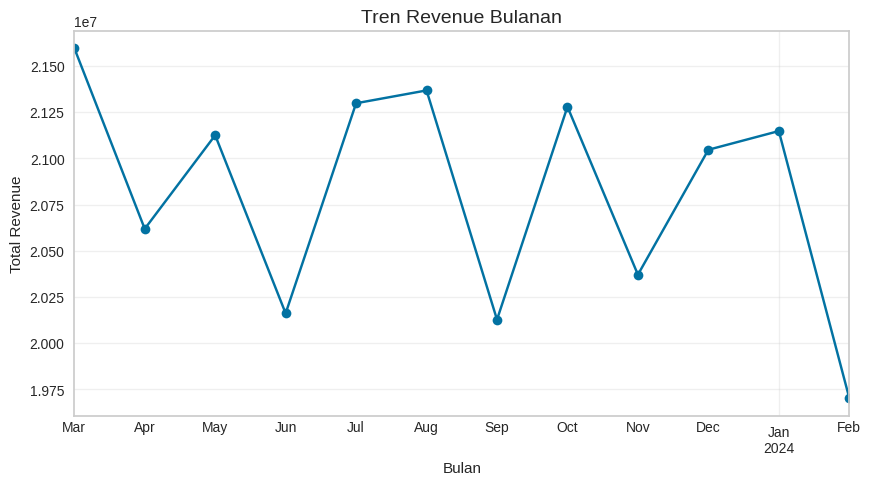

In [21]:
# Pastikan Date sudah datetime
df['Month'] = df['date'].dt.to_period('M')

monthly_revenue = df.groupby('Month')['subtotal'].sum()

plt.figure(figsize=(10,5))
monthly_revenue.plot(kind='line', marker='o')
plt.title('Tren Revenue Bulanan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Total Revenue')
plt.grid(alpha=0.3)
# plt.xticks(rotation=45)
plt.show()

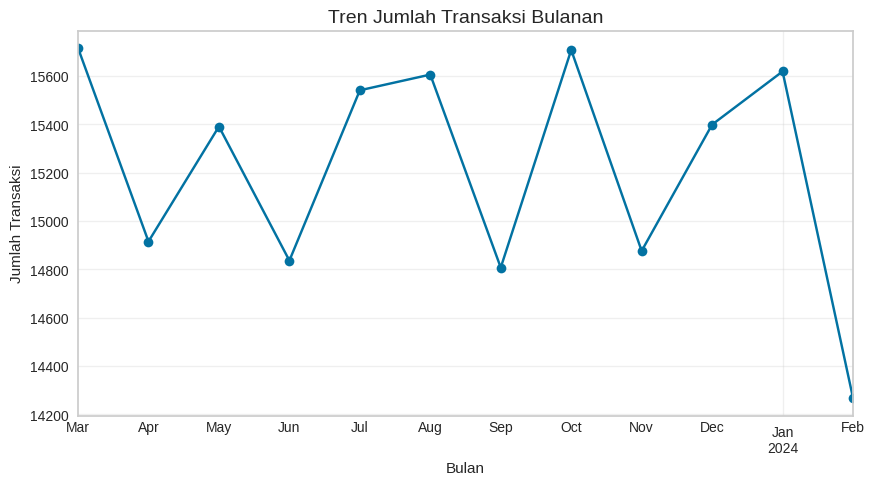

In [22]:
monthly_transactions = df.groupby('Month')['transaction_id'].count()

plt.figure(figsize=(10,5))
monthly_transactions.plot(kind='line', marker='o')
plt.title('Tren Jumlah Transaksi Bulanan', fontsize=14)
plt.xlabel('Bulan')
plt.ylabel('Jumlah Transaksi')
plt.grid(alpha=0.3)
# plt.xticks(rotation=45)
plt.show()

# Data Preprocessing

## Ambil baris data yang memiliki status delivered atau shipped

In [23]:
status_layak = ['Delivered', 'Shipped']
df = df[df['order_status'].isin(status_layak)]
print(df['order_status'].head(10))

0       Shipped
10      Shipped
14      Shipped
17      Shipped
19      Shipped
28    Delivered
44    Delivered
48    Delivered
52    Delivered
54      Shipped
Name: order_status, dtype: object


In [24]:
df = df.dropna()

In [25]:
df = df.drop_duplicates()

## Pisah kolom yang relevan untuk RFM menjadi dataframe tersendiri

In [26]:
df = df.drop(columns=['Month'])
df_rfm = df[['customer_id', 'date', 'transaction_id', 'subtotal']].copy()

temp_columns = [col for col in df.columns if col not in ['customer_id', 'date', 'transaction_id', 'subtotal']]
df_temp = df[temp_columns].copy()

print("RFM DataFrame columns:", df_rfm.columns.tolist())
print("Temporary DataFrame columns:", df_temp.columns.tolist())

RFM DataFrame columns: ['customer_id', 'date', 'transaction_id', 'subtotal']
Temporary DataFrame columns: ['order_status', 'age', 'gender', 'income', 'product_category', 'products', 'payment_method', 'quantity', 'unit_price']


## Perhitungan RFM

In [27]:
snapshot_date = df['date'].max() + pd.Timedelta(days=1)

print(f"Tanggal Snapshot (Referensi): {snapshot_date}")

# Hitung R, F, M per Customer
df_rfm = df_rfm.groupby('customer_id').agg({
    'date': lambda x: (snapshot_date - x.max()).days, # Recency: Jarak hari dari pembelian terakhir
    'transaction_id': 'nunique',                         # Frequency: Jumlah kali transaksi
    'subtotal': 'sum'                                # Monetary: Total uang yang dibelanjakan
})

df_rfm.rename(columns={
    'date': 'Recency',
    'transaction_id': 'Frequency',
    'subtotal': 'Monetary'
}, inplace=True)

print("Sample Tabel RFM")
display(df_rfm.head())

Tanggal Snapshot (Referensi): 2024-03-01 00:00:00
Sample Tabel RFM


Recency  Frequency     Monetary
customer_id                                 
10000.0          103          3  2324.509346
10001.0          105          4  4256.918342
10002.0           95          4  3747.140929
10003.0          228          1  1890.735874
10005.0          246          1  3073.147975

## Cek distribusi data tiap kolom

In [28]:
print(df_rfm.skew())

Recency      0.452931
Frequency    1.345796
Monetary     1.333794
dtype: float64


In [29]:
# 1. Inisialisasi PowerTransformer
# standardize=True artinya dia sekalian melakukan Scaling (Z-Score)
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# 2. Fit & Transform data RFM asli (bukan yang sudah di-log)
rfm_transformed = pt.fit_transform(df_rfm)

# 3. Kembalikan ke DataFrame
rfm_scaled_df = pd.DataFrame(rfm_transformed, index=df_rfm.index, columns=df_rfm.columns)

print("--- Skewness Setelah Yeo-Johnson Transformation ---")
print(rfm_scaled_df.skew())

print("\n--- Sample Data Akhir ---")
display(rfm_scaled_df.head())

--- Skewness Setelah Yeo-Johnson Transformation ---
Recency     -0.203351
Frequency    0.231643
Monetary    -0.071731
dtype: float64

--- Sample Data Akhir ---


Recency  Frequency  Monetary
customer_id                               
10000.0     -0.130072   1.303840  0.219217
10001.0     -0.109449   1.669786  0.984074
10002.0     -0.214703   1.669786  0.809740
10003.0      0.904203  -0.980469 -0.008470
10005.0      1.025502  -0.980469  0.553036

# Modelling

## K-means

Sedang menghitung inertia untuk k=1 sampai 14...

Jumlah cluster optimal (best_k) ditemukan: 4


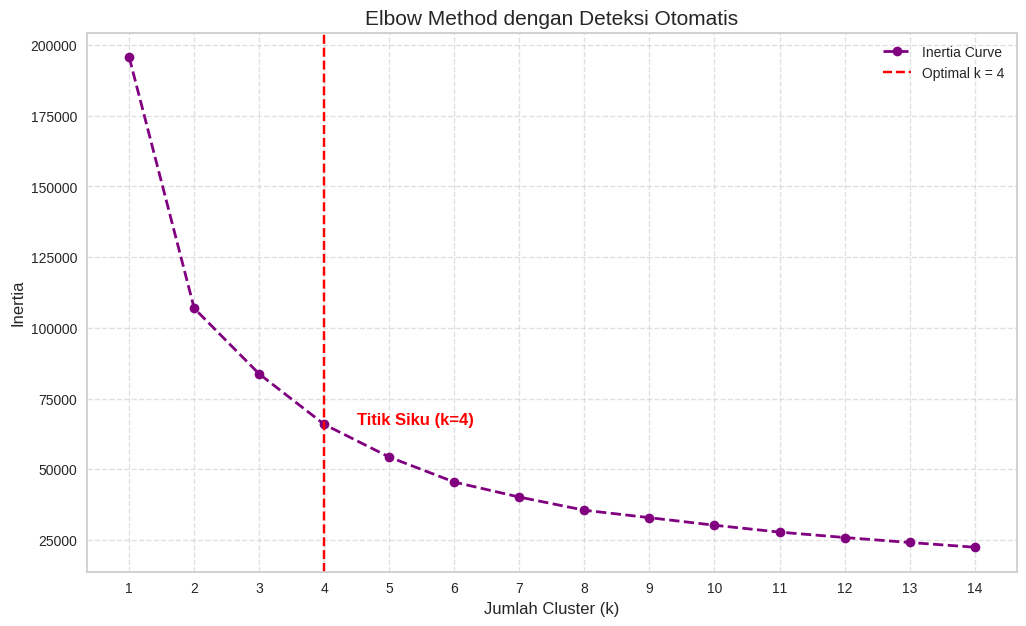

In [30]:
# --- 1. PERHITUNGAN (WAJIB ADA) ---
# Ini adalah kode lama Anda. Kita butuh ini untuk menghitung Inertia.
inertia = []
k_range = range(1, 15) # Menggunakan range 1-15 sesuai kode terakhir Anda

print("Sedang menghitung inertia untuk k=1 sampai 14...")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled_df)
    inertia.append(kmeans.inertia_)

# --- 2. DETEKSI OTOMATIS (BARU) ---
# Ini fitur tambahan agar python yang menentukan angkanya, bukan mata kita.
kl = KneeLocator(k_range, inertia, curve="convex", direction="decreasing")
best_k = kl.elbow

print(f"\nJumlah cluster optimal (best_k) ditemukan: {best_k}")

# --- 3. VISUALISASI UPGRADED ---
# Ini menggantikan plt.plot biasa dengan versi yang ada garis merahnya
plt.figure(figsize=(12, 7))
plt.plot(k_range, inertia, marker='o', linestyle='--', color='purple', linewidth=2, label='Inertia Curve')

# Tambahkan garis vertikal di titik optimal
if best_k:
    plt.axvline(x=best_k, color='red', linestyle='--', label=f'Optimal k = {best_k}')
    plt.text(best_k + 0.5, inertia[k_range.index(best_k)], f'Titik Siku (k={best_k})',
             color='red', fontweight='bold', fontsize=12)

plt.title('Elbow Method dengan Deteksi Otomatis', fontsize=15)
plt.xlabel('Jumlah Cluster (k)', fontsize=12)
plt.ylabel('Inertia', fontsize=12)
plt.xticks(k_range)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Simpan k optimal ke variabel global agar bisa dipakai di tahap selanjutnya
optimal_k_clusters = best_k

## k cluster sesuai jumlah segment

In [31]:
k_business = 5
kmeans_final = KMeans(n_clusters=k_business, random_state=42, n_init=10)

# 2. Fit model ke data yang sudah discaling (rfm_scaled_df)
kmeans_final.fit(rfm_scaled_df)

# 3. Masukkan label cluster ke DataFrame asli (agar bisa dibaca manusia)
# Penting: Kita masukkan ke 'rfm' (data asli), bukan 'rfm_scaled_df' (data hasil transformasi)
df_rfm['Cluster'] = kmeans_final.labels_

# --- INTERPRETASI PROFIL CLUSTER ---
# Kita hitung rata-rata R, F, M untuk setiap cluster
cluster_summary = df_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Cluster': 'count' # Untuk melihat jumlah member per cluster
}).rename(columns={'Cluster': 'Count'})

# Tampilkan hasil
print(f"Model terbentuk dengan {k_business} cluster!")
print("\n--- Profil Rata-rata Setiap Cluster ---")
display(cluster_summary.sort_values(by='Monetary', ascending=False))

Model terbentuk dengan 5 cluster!

--- Profil Rata-rata Setiap Cluster ---


Recency  Frequency     Monetary  Count
Cluster                                           
2         40.607774   2.874975  4442.761847  15101
0        166.371898   2.282310  2938.446593  16241
4        225.747378   1.000000  2342.640408  11729
3         44.502700   1.171198  1202.518891  10555
1        228.293144   1.029495   462.776640  11595

## k cluster sesuai grafik

In [32]:
# kmeans_final = KMeans(n_clusters=optimal_k_clusters, random_state=42, n_init=10)

# # 2. Fit model ke data yang sudah discaling (rfm_scaled_df)
# kmeans_final.fit(rfm_scaled_df)

# # 3. Masukkan label cluster ke DataFrame asli (agar bisa dibaca manusia)
# # Penting: Kita masukkan ke 'rfm' (data asli), bukan 'rfm_scaled_df' (data hasil transformasi)
# df_rfm['Cluster'] = kmeans_final.labels_

# # --- INTERPRETASI PROFIL CLUSTER ---
# # Kita hitung rata-rata R, F, M untuk setiap cluster
# cluster_summary = df_rfm.groupby('Cluster').agg({
#     'Recency': 'mean',
#     'Frequency': 'mean',
#     'Monetary': 'mean',
#     'Cluster': 'count' # Untuk melihat jumlah member per cluster
# }).rename(columns={'Cluster': 'Count'})

# # Tampilkan hasil
# print(f"Model terbentuk dengan {optimal_k_clusters} cluster!")
# print("\n--- Profil Rata-rata Setiap Cluster ---")
# display(cluster_summary.sort_values(by='Monetary', ascending=False))

## Kasih nama segment

In [33]:
# Mapping 5 Cluster sesuai analisis di atas
segment_map_5 = {
    2: 'Loyalists',      # R:Low, F:High, M:High (Terbaik)
    0: 'At Risk',        # R:High, F:High, M:High (Mantan Loyal)
    3: 'New Customers',  # R:Low, F:Low, M:Low   (Baru Masuk)
    1: 'Hibernating',    # R:High, F:Low, M:Low  (Lama Hilang & Kecil)
    4: 'Big Spenders'    # R:High, F:Low, M:High (Sekali Beli tapi Mahal)
}

# Terapkan ke DataFrame
df_rfm['Customer_Segment'] = df_rfm['Cluster'].map(segment_map_5)

# Tampilkan Hasil Akhir untuk Verifikasi
print("--- Hasil Segmentasi dengan 5 Label ---")
display(df_rfm[['Recency', 'Frequency', 'Monetary', 'Customer_Segment']].sample(10))

--- Hasil Segmentasi dengan 5 Label ---


Recency  Frequency     Monetary Customer_Segment
customer_id                                                  
77701.0           69          1   119.468626    New Customers
62298.0          103          1  2353.035823     Big Spenders
48486.0          320          2  5186.620863          At Risk
91214.0           37          1  3137.613501    New Customers
73933.0            1          1  1251.419085    New Customers
85675.0           44          4  1964.978680        Loyalists
63310.0           65          2  2276.244118          At Risk
23873.0          109          3  2456.715537          At Risk
41399.0           66          3  4954.066837        Loyalists
22292.0           15          2   677.085340    New Customers

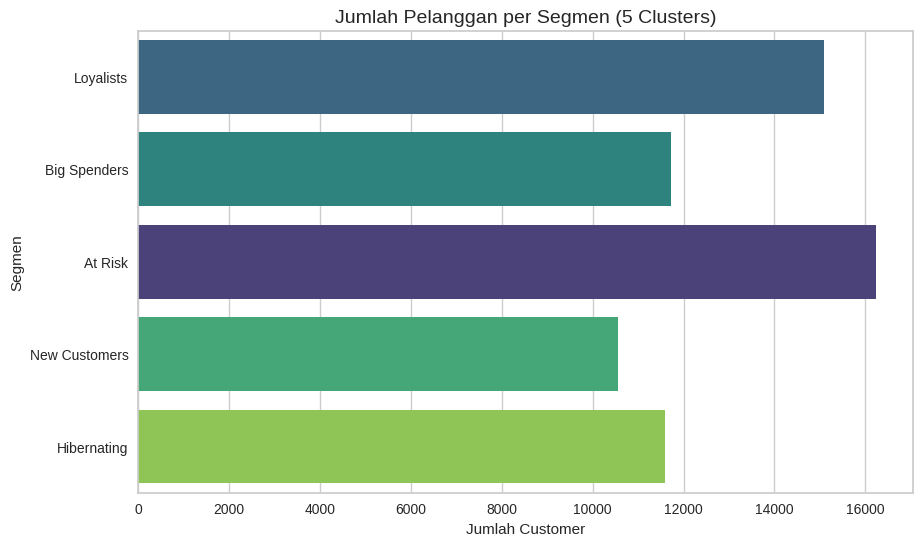

In [34]:
plt.figure(figsize=(10, 6))
# Mengurutkan agar warnanya konsisten
order_list = ['Loyalists', 'Big Spenders', 'At Risk', 'New Customers', 'Hibernating']
sns.countplot(y='Customer_Segment', hue='Customer_Segment', data=df_rfm, order=order_list, palette='viridis')
plt.title('Jumlah Pelanggan per Segmen (5 Clusters)', fontsize=14)
plt.xlabel('Jumlah Customer')
plt.ylabel('Segmen')
plt.show()

# Evaluation

## Skor silhoutte

In [35]:
# --- 1. HITUNG SKOR RATA-RATA ---
# Kita gunakan data yang sudah di-scaling (rfm_scaled_df) karena K-Means bekerja berdasarkan jarak
score = silhouette_score(rfm_scaled_df, kmeans.labels_)

print(f"Silhouette Score untuk k=5 adalah: {score:.3f}")

# --- INTERPRETASI SINGKAT ---
if score > 0.5:
    print("Kualitas Cluster: SANGAT KUAT (Struktur terpisah jelas)")
elif score > 0.25:
    print("Kualitas Cluster: CUKUP (Struktur terlihat, tapi ada overlap wajar)")
else:
    print("Kualitas Cluster: LEMAH (Data mungkin terlalu menyatu/homogen)")


Silhouette Score untuk k=5 adalah: 0.311
Kualitas Cluster: CUKUP (Struktur terlihat, tapi ada overlap wajar)


## Versi strict, hapus lebih bnyk outlier

In [36]:
Q1 = rfm_scaled_df.quantile(0.05)
Q3 = rfm_scaled_df.quantile(0.95)
IQR = Q3 - Q1

# Filter data
rfm_clean = rfm_scaled_df[~((rfm_scaled_df < (Q1 - 1.5 * IQR)) | (rfm_scaled_df > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Ukuran data awal: {rfm_scaled_df.shape}")
print(f"Ukuran data setelah strict cleaning: {rfm_clean.shape}")

# Re-Run K-Means pada data yang lebih bersih
kmeans_clean = KMeans(n_clusters=5, random_state=42, n_init=10)
labels_clean = kmeans_clean.fit_predict(rfm_clean)

score_clean = silhouette_score(rfm_clean, labels_clean)
print(f"\nSilhouette Score setelah Outlier Removal: {score_clean:.3f}")

Ukuran data awal: (65221, 3)
Ukuran data setelah strict cleaning: (65221, 3)

Silhouette Score setelah Outlier Removal: 0.332


In [37]:
sample_silhouette_values = silhouette_samples(rfm_scaled_df, kmeans.labels_)

# 2. Masukkan skor ini ke dalam DataFrame asli untuk dianalisis
# Kita buat copy agar tidak mengganggu data utama jika ingin eksperimen
df_eval = df_rfm.copy()
df_eval['Silhouette_Score'] = sample_silhouette_values

# 3. Hitung Rata-rata Skor per Segmen
cluster_silhouette_scores = df_eval.groupby('Customer_Segment')['Silhouette_Score'].mean().sort_values(ascending=False)

print("--- Rata-rata Silhouette Score per Cluster ---")
print(cluster_silhouette_scores)

--- Rata-rata Silhouette Score per Cluster ---
Customer_Segment
Big Spenders     0.353866
Hibernating      0.352242
New Customers    0.340111
At Risk          0.289222
Loyalists        0.248051
Name: Silhouette_Score, dtype: float64


## Buat visualisasi PCA

Sedang melakukan reduksi dimensi dengan PCA...

--- Sample Data setelah PCA (Siap Visualisasi) ---


PC1 (Principal Component 1)  PC2 (Principal Component 2) Customer_Segment
0                     1.040306                     0.214545          At Risk
1                     1.731307                     0.656822        Loyalists
2                     1.674287                     0.483393        Loyalists
3                    -1.058516                     0.609561     Big Spenders
4                    -0.774759                     0.979994     Big Spenders


Explained Variance Ratio per Komponen: [0.60987549 0.2667665 ]
Total Informasi yang Terjaga dalam Visualisasi 2D ini: 87.66%


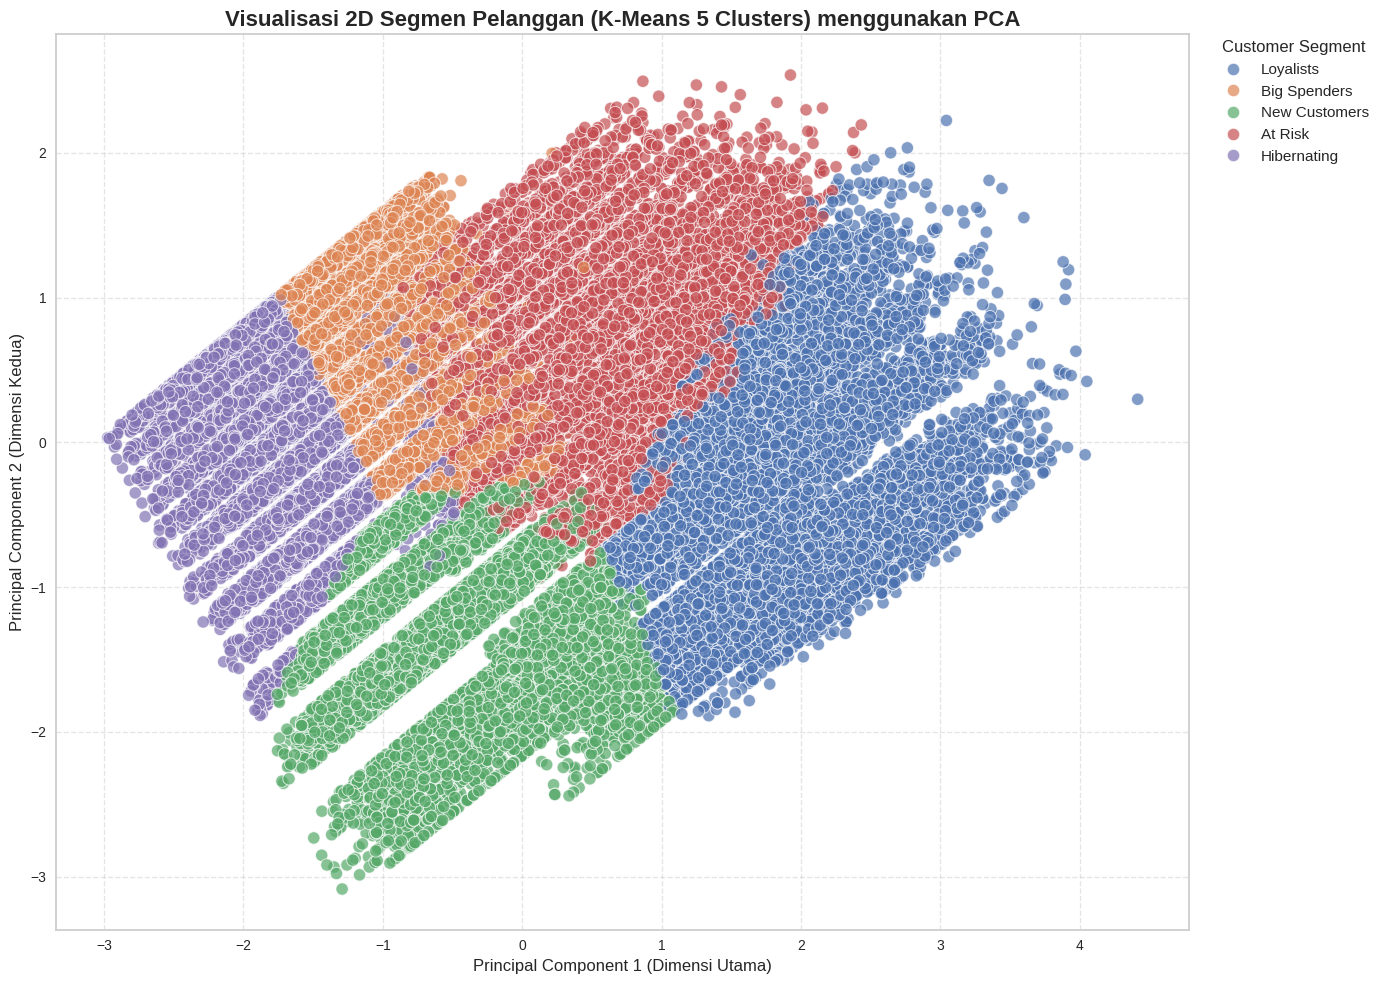

In [38]:
# --- TAHAP 1: PENERAPAN PCA ---
print("Sedang melakukan reduksi dimensi dengan PCA...")
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled_df)
df_pca = pd.DataFrame(data=pca_components, columns=['PC1 (Principal Component 1)', 'PC2 (Principal Component 2)'])
df_pca['Customer_Segment'] = df_rfm['Customer_Segment'].values

print("\n--- Sample Data setelah PCA (Siap Visualisasi) ---")
display(df_pca.head())


# --- TAHAP 2: EVALUASI INFORMASI PCA ---
# 'Explained Variance Ratio' menunjukkan berapa persen informasi yang ditangkap tiap komponen.
variance_ratio = pca.explained_variance_ratio_
total_variance = sum(variance_ratio) * 100

print(f"\nExplained Variance Ratio per Komponen: {variance_ratio}")
print(f"Total Informasi yang Terjaga dalam Visualisasi 2D ini: {total_variance:.2f}%")
# Insight: Jika Total > 80%, visualisasi ini sangat representatif dan bisa dipercaya.


# --- TAHAP 3: VISUALISASI 2D SCATTER PLOT ---
plt.figure(figsize=(14, 10))
# Mengatur urutan legenda agar rapi (opsional, sesuaikan dengan preferensi Anda)
# Misalnya diurutkan dari yang paling 'bagus' ke paling 'buruk'
hue_order = ['Loyalists', 'Big Spenders', 'New Customers', 'At Risk', 'Hibernating']
# Filter hue_order hanya untuk segmen yang benar-benar ada di data saat ini
existing_segments = [seg for seg in hue_order if seg in df_pca['Customer_Segment'].unique()]

sns.scatterplot(
    x='PC1 (Principal Component 1)',
    y='PC2 (Principal Component 2)',
    hue='Customer_Segment', # Warna dibedakan berdasarkan segmen
    data=df_pca,
    palette='deep',         # Pilihan palet warna: 'deep', 'viridis', 'Set1', dll.
    hue_order=existing_segments, # Memastikan urutan legenda konsisten
    s=80,                   # Ukuran titik
    alpha=0.7,              # Transparansi (agar terlihat jika ada titik menumpuk)
    edgecolor='w'           # Garis putih tipis di pinggir titik agar lebih tegas
)

plt.title('Visualisasi 2D Segmen Pelanggan (K-Means 5 Clusters) menggunakan PCA', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component 1 (Dimensi Utama)', fontsize=12)
plt.ylabel('Principal Component 2 (Dimensi Kedua)', fontsize=12)

plt.legend(title='Customer Segment', title_fontsize=12, fontsize=11,
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

## Gabungin dataframe jadi satu

In [39]:
df_final = pd.concat([
    df_temp.reset_index(drop=True),
    df_rfm.reset_index(drop=True),
    df_pca.reset_index(drop=True)
], axis=1)

# 1. Hapus kolom duplikat (kita hanya simpan satu kolom 'Customer_Segment')
df_final = df_final.loc[:, ~df_final.columns.duplicated()]

# 2. Cek apakah sekarang sudah benar (Harusnya hanya muncul 1 kali)
print("Daftar Kolom saat ini:", df_final.columns.tolist())

df_final.head(10)

Daftar Kolom saat ini: ['order_status', 'age', 'gender', 'income', 'product_category', 'products', 'payment_method', 'quantity', 'unit_price', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Customer_Segment', 'PC1 (Principal Component 1)', 'PC2 (Principal Component 2)']


order_status   age  gender  income product_category            products  \
0      Shipped  21.0    Male     Low         Clothing      Cycling shorts   
1      Shipped  64.0  Female     Low       Home Decor     Screwdriver set   
2      Shipped  32.0  Female    High         Clothing          V-neck tee   
3      Shipped  19.0  Female    High      Electronics  Samsung Galaxy Tab   
4      Shipped  69.0    Male     Low       Home Decor           Bookshelf   
5    Delivered  43.0    Male  Medium       Home Decor            Curtains   
6    Delivered  58.0  Female    High         Clothing       Bodycon dress   
7    Delivered  35.0  Female  Medium       Home Decor           Comforter   
8    Delivered  59.0    Male    High      Electronics          Android TV   
9      Shipped  46.0    Male     Low         Clothing            Sneakers   

  payment_method  quantity  unit_price  Recency  Frequency     Monetary  \
0     Debit Card       3.0  108.028757    103.0        3.0  2324.509346   
1    Credit Card       4.0   90.981870    105.0        4.0  4256.918342   
2           Cash       6.0  297.726039     95.0        4.0  3747.140929   
3           Cash       3.0  139.786855    228.0        1.0  1890.735874   
4           Cash       2.0  469.659639    246.0        1.0  3073.147975   
5           Cash       8.0  333.859664     16.0        1.0  3383.222304   
6           Cash       3.0  312.976573     34.0        3.0  6239.019428   
7    Credit Card       7.0  346.719593    122.0        1.0    49.274554   
8         PayPal       2.0  281.600169     61.0        3.0  2014.622972   
9     Debit Card       4.0  129.756972    292.0        1.0   638.851449   

   Cluster Customer_Segment  PC1 (Principal Component 1)  \
0      0.0          At Risk                     1.040306   
1      2.0        Loyalists                     1.731307   
2      2.0        Loyalists                     1.674287   
3      4.0     Big Spenders                    -1.058516   
4      4.0     Big Spenders                    -0.774759   
5      3.0    New Customers                     0.430180   
6      2.0        Loyalists                     2.267304   
7      1.0      Hibernating                    -2.025080   
8      2.0        Loyalists                     1.170918   
9      1.0      Hibernating                    -1.833899   

   PC2 (Principal Component 2)  
0                     0.214545  
1                     0.656822  
2                     0.483393  
3                     0.609561  
4                     0.979994  
5                    -1.087945  
6                     0.055546  
7                    -1.181935  
8                    -0.287503  
9                     0.507058

In [40]:
# --- TAHAP 1: PERSIAPAN DATA ---
# Pastikan df_final memiliki kolom 'customer_id' (bukan di index)
if 'customer_id' not in df_final.columns:
    df_final = df_final.reset_index()
    if 'index' in df_final.columns: df_final.rename(columns={'index': 'customer_id'}, inplace=True)

# Gabungkan info Segmen ke Data Transaksi Asli (df)
# Tujuannya: Agar kita tahu "Orang-orang di segmen Loyalists itu belanjanya apa aja sih di data asli?"
df_transaksi_lengkap = df.merge(df_final[['customer_id', 'Customer_Segment']], on='customer_id', how='left')

# --- TAHAP 2: FUNGSI ANALISIS ---
def bedah_karakteristik_cluster(target_segments):
    print("="*80)
    print(f"{'BEDAH PROFIL & KARAKTERISTIK SETIAP CLUSTER':^80}")
    print("="*80)

    for segmen in target_segments:
        # Filter Data
        # A. Data Unik (df_final): Untuk Umur, Income, RFM
        data_profil = df_final[df_final['Customer_Segment'] == segmen]

        # B. Data Transaksi (df_transaksi_lengkap): Untuk Produk & Payment
        data_belanja = df_transaksi_lengkap[df_transaksi_lengkap['Customer_Segment'] == segmen]

        # Skip jika data kosong
        if len(data_profil) == 0: continue

        print(f"\n🌟 CLUSTER: {segmen.upper()}")
        print(f"   (Jumlah Pelanggan: {len(data_profil)} orang)")
        print("-" * 50)

        # 1. DEMOGRAFI (Umur, Gender, Income)
        # Handle Umur (pastikan numerik)
        if 'age' in data_profil.columns and pd.api.types.is_numeric_dtype(data_profil['age']):
            rata_umur = data_profil['age'].mean()
        else:
            rata_umur = 0 # Default jika error

        # Handle Gender
        if 'gender' in data_profil.columns:
            gender_dominan = data_profil['gender'].mode()[0]
            persen_gender = (data_profil['gender'].value_counts(normalize=True).max()) * 100
        else:
            gender_dominan = "N/A"
            persen_gender = 0

        # --- PERBAIKAN DI SINI (HANDLE INCOME) ---
        print(f"👥 DEMOGRAFI")
        print(f"   • Rata-rata Umur   : {rata_umur:.1f} Tahun")
        print(f"   • Dominasi Gender  : {gender_dominan} ({persen_gender:.1f}%)")

        if 'income' in data_profil.columns:
            # Cek apakah Income itu Angka atau Teks?
            if pd.api.types.is_numeric_dtype(data_profil['income']):
                # Jika Angka -> Hitung Rata-rata
                rata_income = data_profil['income'].mean()
                range_income = f"{data_profil['income'].min():,.0f} - {data_profil['income'].max():,.0f}"
                print(f"   • Profil Income    : Rata-rata {rata_income:,.0f} (Range: {range_income})")
            else:
                # Jika Teks (Low/Medium/High) -> Cari yang Dominan
                try:
                    income_dominan = data_profil['income'].mode()[0]
                    income_pct = (data_profil['income'].value_counts(normalize=True).max()) * 100
                    print(f"   • Profil Income    : Dominan Kategori '{income_dominan}' ({income_pct:.1f}%)")
                except:
                    print(f"   • Profil Income    : Data tidak valid")
        else:
            print(f"   • Profil Income    : Data tidak tersedia")

        # 2. PERILAKU RFM
        # Gunakan kolom RFM (Recency, Frequency, Monetary)
        # Pastikan kolom ini numerik, biasanya aman karena hasil kalkulasi
        try:
            r_avg = data_profil['Recency'].mean()
            f_avg = data_profil['Frequency'].mean()
            m_avg = data_profil['Monetary'].mean()

            print(f"\n📊 PERILAKU BELANJA (RFM)")
            print(f"   • Recency (Terakhir Beli) : {r_avg:.1f} hari yang lalu")
            print(f"   • Frequency (Seringnya)   : {f_avg:.1f} kali transaksi")
            print(f"   • Monetary (Total Uang)   : {m_avg:,.0f}")
        except:
             print(f"\n📊 PERILAKU BELANJA (RFM) - Error kalkulasi (cek tipe data)")

        # 3. MINAT PRODUK & CARA BAYAR
        print(f"\n🛒 PREFERENSI TRANSAKSI")

        # Top 3 Produk
        if 'product_category' in data_belanja.columns:
            top_produk = data_belanja['product_category'].value_counts().head(3)
            list_produk = ", ".join([f"{k} ({v})" for k,v in top_produk.items()])
            print(f"   • Kategori Favorit : {list_produk}")

        # Top Payment
        if 'payment_method' in data_belanja.columns:
            top_payment = data_belanja['payment_method'].value_counts().head(3)
            list_payment = ", ".join([f"{k} ({v})" for k,v in top_payment.items()])
            print(f"   • Cara Bayar       : {list_payment}")

        print("\n" + "."*80)

# --- EKSEKUSI ---
# Urutan segmen
urutan_segmen = ['Loyalists', 'Big Spenders', 'New Customers', 'At Risk', 'Hibernating']

# Filter segmen yang ada (pastikan df_final sudah di-reset index dan kolom duplikat dibuang seperti langkah sebelumnya)
segmen_ada = [s for s in urutan_segmen if s in df_final['Customer_Segment'].unique()]

bedah_karakteristik_cluster(segmen_ada)

                  BEDAH PROFIL & KARAKTERISTIK SETIAP CLUSTER                   

🌟 CLUSTER: LOYALISTS
   (Jumlah Pelanggan: 15101 orang)
--------------------------------------------------
👥 DEMOGRAFI
   • Rata-rata Umur   : 29.6 Tahun
   • Dominasi Gender  : Male (65.2%)
   • Profil Income    : Dominan Kategori 'Medium' (48.2%)

📊 PERILAKU BELANJA (RFM)
   • Recency (Terakhir Beli) : 40.6 hari yang lalu
   • Frequency (Seringnya)   : 2.9 kali transaksi
   • Monetary (Total Uang)   : 4,443

🛒 PREFERENSI TRANSAKSI
   • Kategori Favorit : Electronics (4221), Grocery (3598), Clothing (2937)
   • Cara Bayar       : Credit Card (4966), Debit Card (4036), Cash (4026)

................................................................................

🌟 CLUSTER: BIG SPENDERS
   (Jumlah Pelanggan: 11729 orang)
--------------------------------------------------
👥 DEMOGRAFI
   • Rata-rata Umur   : 29.4 Tahun
   • Dominasi Gender  : Male (64.4%)
   • Profil Income    : Dominan Kategori 'Medium' (48

In [41]:
df_transaksi_lengkap.columns.tolist()

['customer_id',
 'transaction_id',
 'date',
 'order_status',
 'age',
 'gender',
 'income',
 'product_category',
 'products',
 'payment_method',
 'quantity',
 'unit_price',
 'subtotal',
 'Customer_Segment']

In [42]:
# Cek Distribusi Global (Seluruh Data)
print("--- STATISTIK GLOBAL (SEMUA DATA) ---")
print(df_final['gender'].value_counts(normalize=True) * 100)
print("\n")
print(df_final['income'].value_counts(normalize=True) * 100)
print("\n")
print(df_final['age'].value_counts(normalize=True) * 100)

--- STATISTIK GLOBAL (SEMUA DATA) ---
gender
Male      63.290491
Female    36.709509
Name: proportion, dtype: float64


income
Medium    43.501118
Low       30.715858
High      25.783024
Name: proportion, dtype: float64


age
26.0    11.801253
22.0    11.193610
46.0    11.002441
20.0     9.816171
19.0     7.722703
34.0     5.780293
23.0     4.713503
55.0     2.191612
21.0     2.113950
48.0     1.811835
24.0     1.641149
70.0     0.813320
43.0     0.785157
30.0     0.765528
28.0     0.758701
47.0     0.753580
56.0     0.749313
41.0     0.747606
69.0     0.745899
60.0     0.739925
33.0     0.739925
59.0     0.736512
57.0     0.733951
61.0     0.733098
36.0     0.732244
64.0     0.730537
27.0     0.729684
35.0     0.723710
58.0     0.722857
40.0     0.722857
42.0     0.721150
62.0     0.719443
52.0     0.716883
65.0     0.716883
63.0     0.714322
51.0     0.713469
68.0     0.712615
49.0     0.710055
32.0     0.702374
25.0     0.701521
29.0     0.700667
37.0     0.697254
39.0     0.696400



>>> VISUALISASI CLUSTER: LOYALISTS <<<


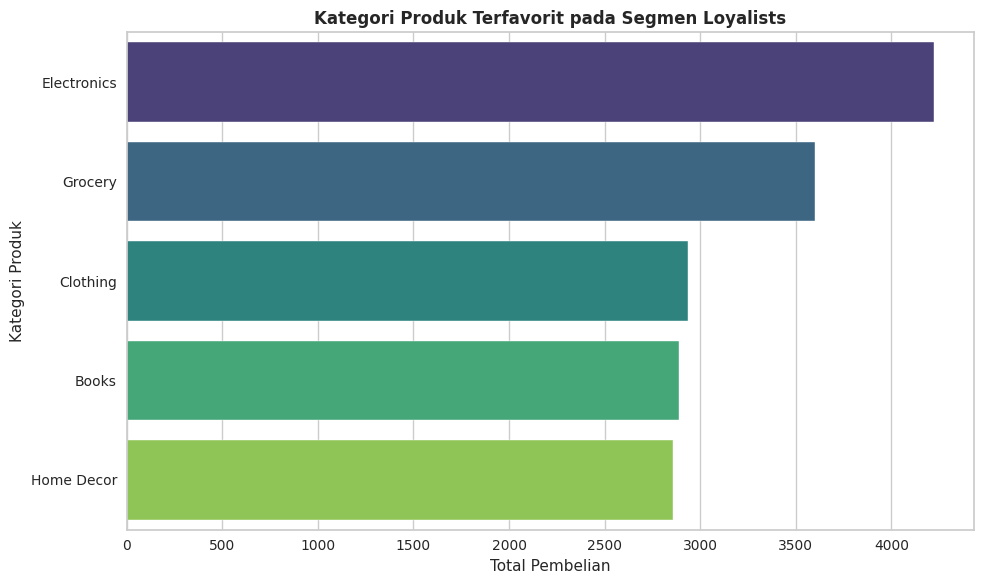

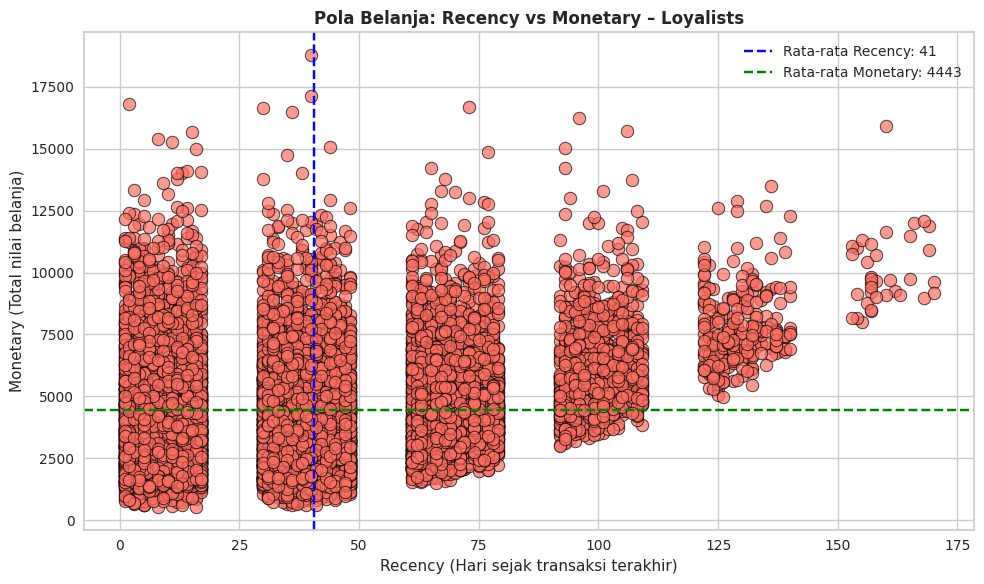

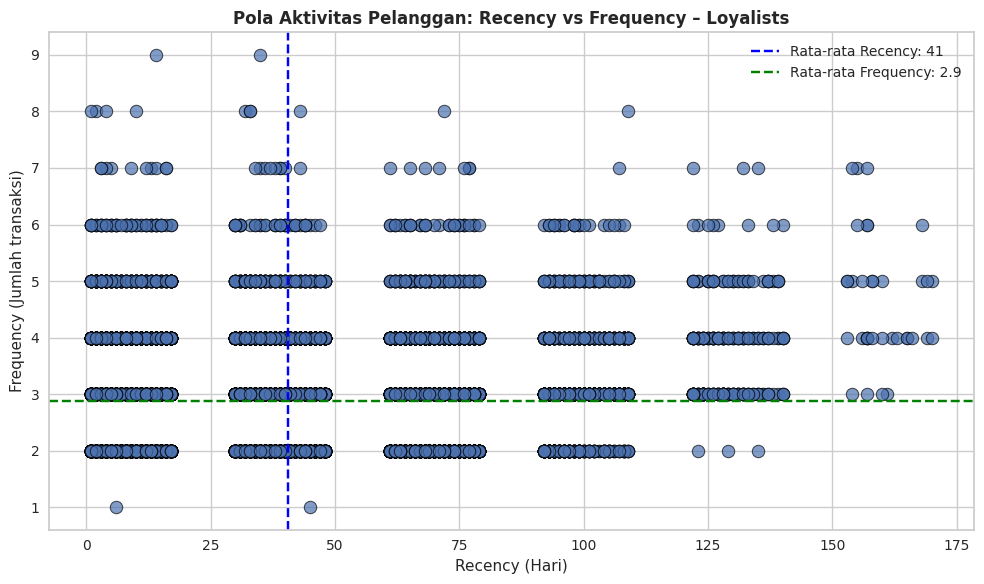

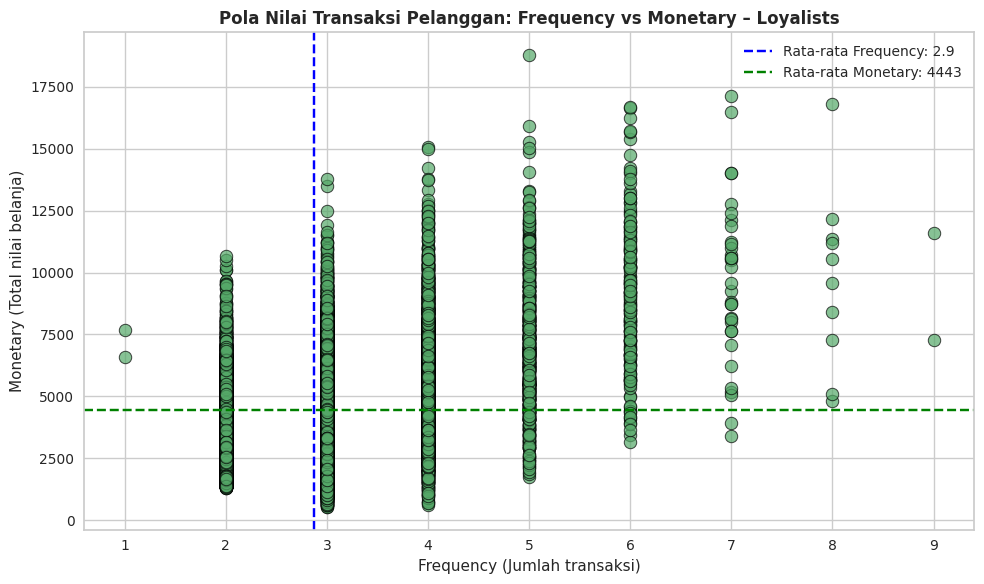


>>> VISUALISASI CLUSTER: BIG SPENDERS <<<


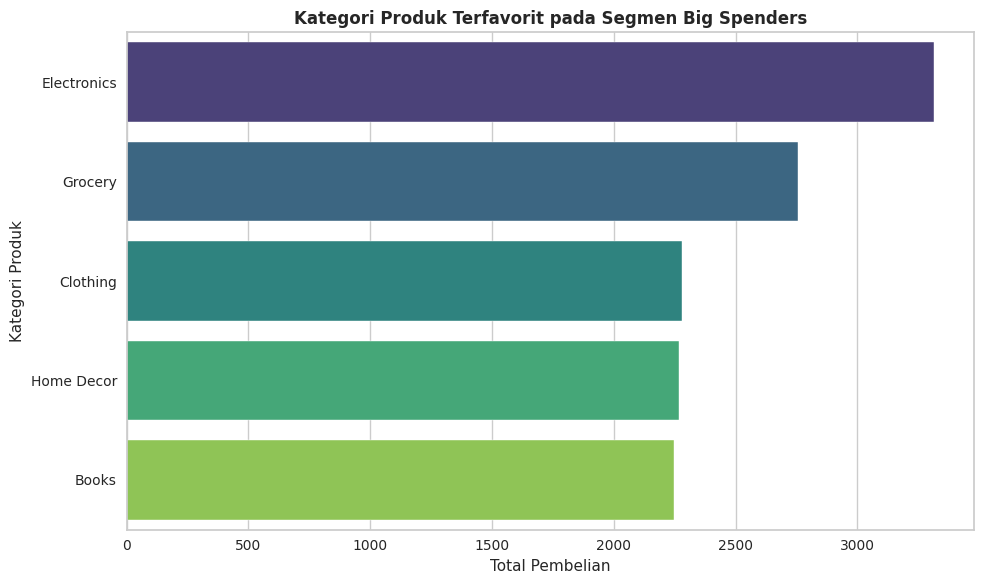

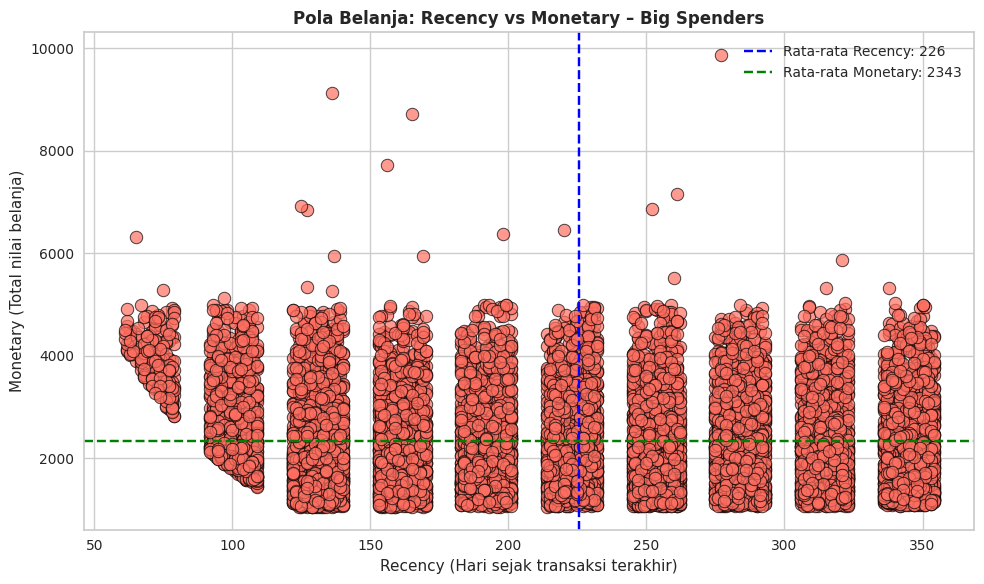

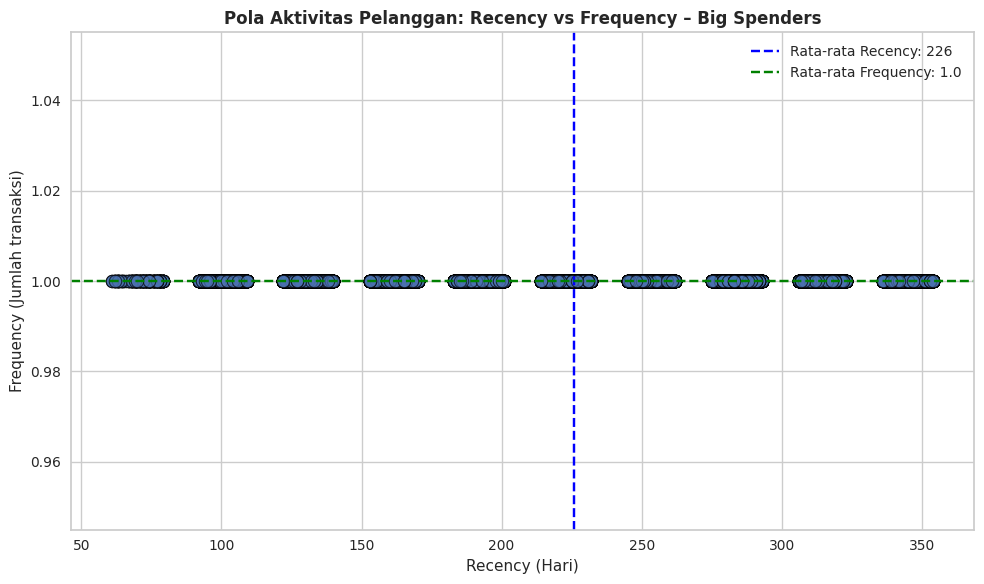

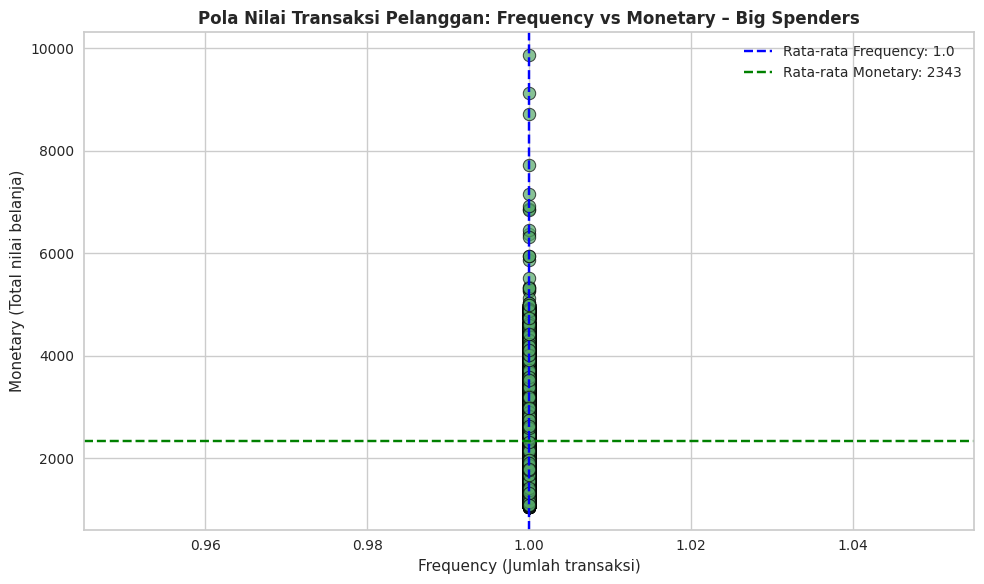


>>> VISUALISASI CLUSTER: NEW CUSTOMERS <<<


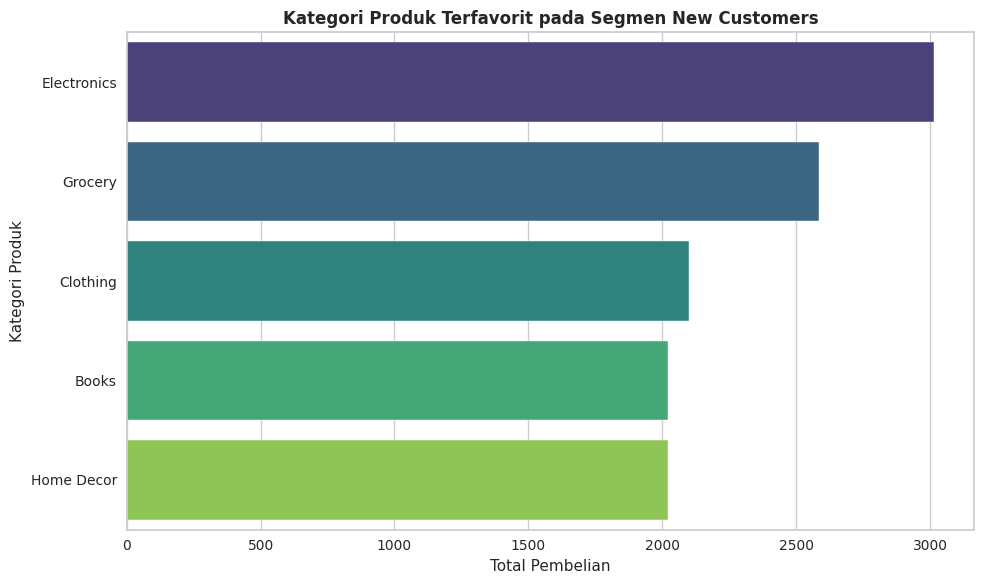

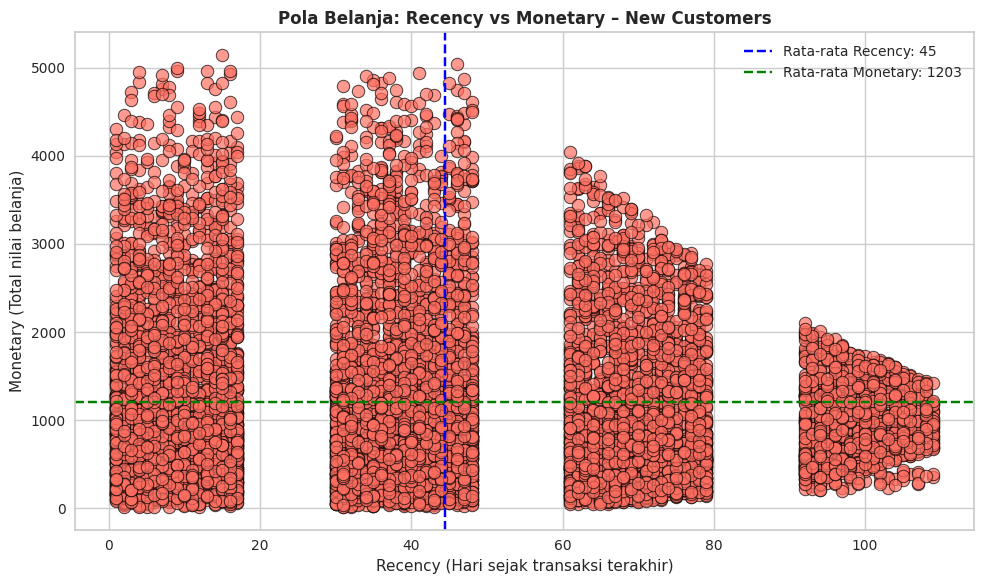

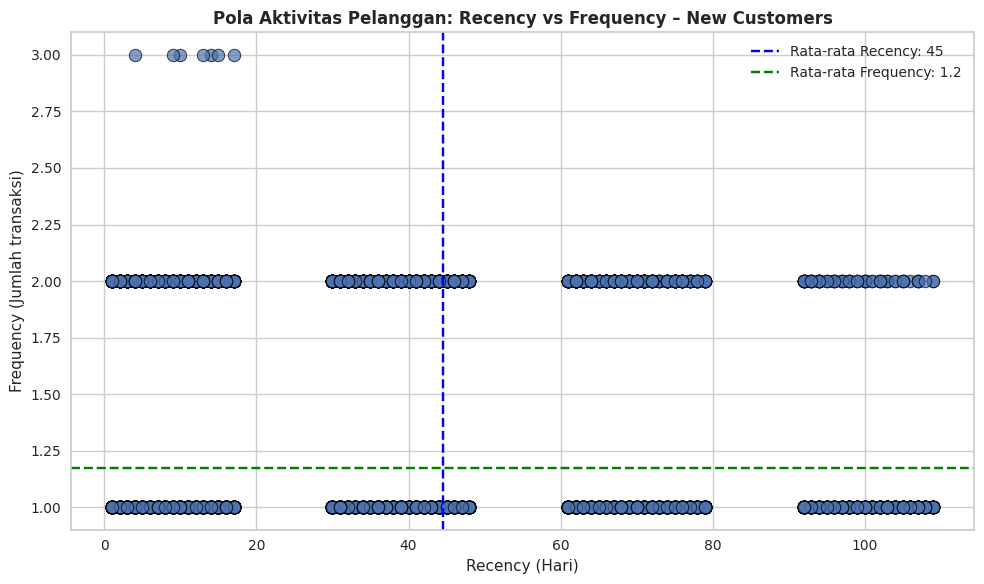

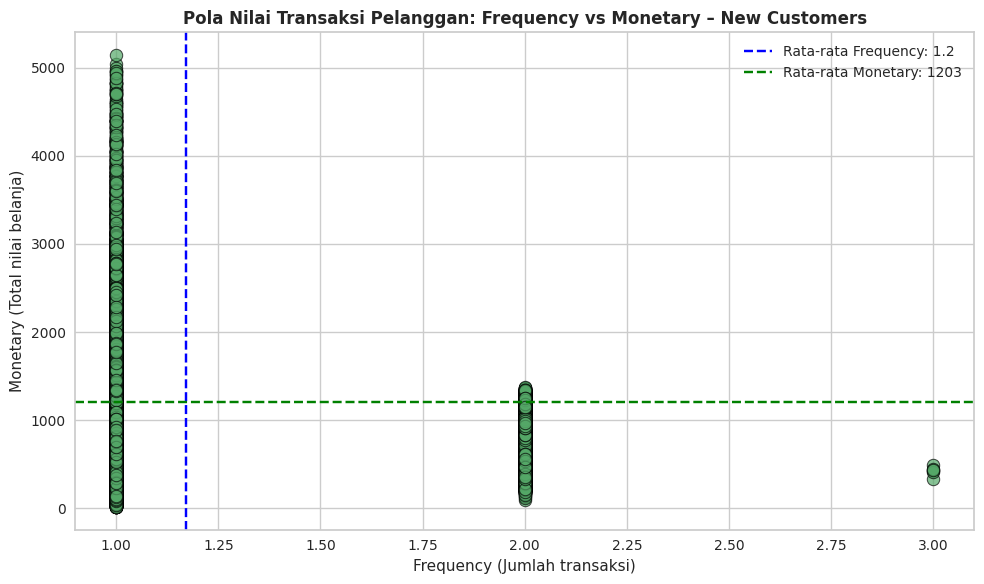


>>> VISUALISASI CLUSTER: AT RISK <<<


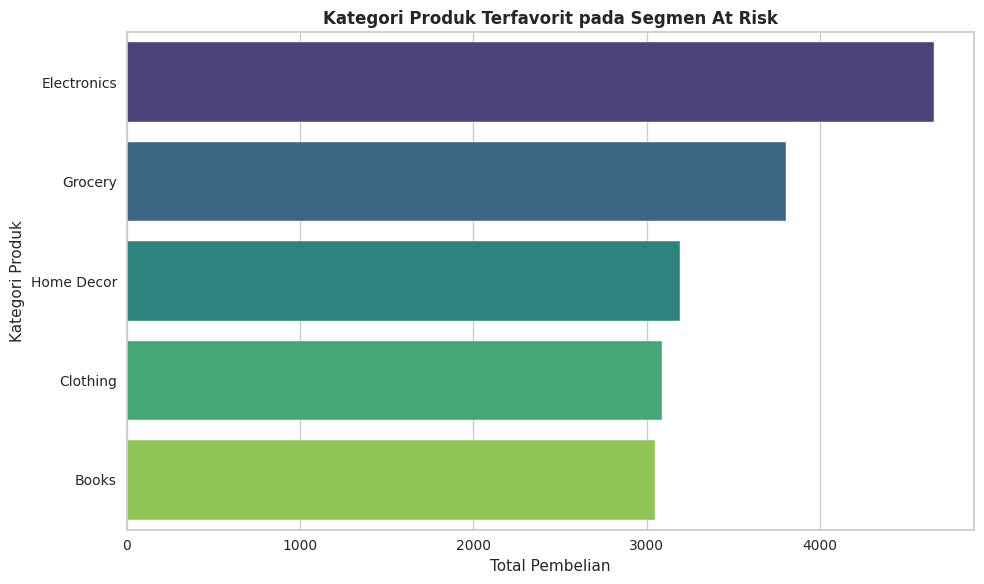

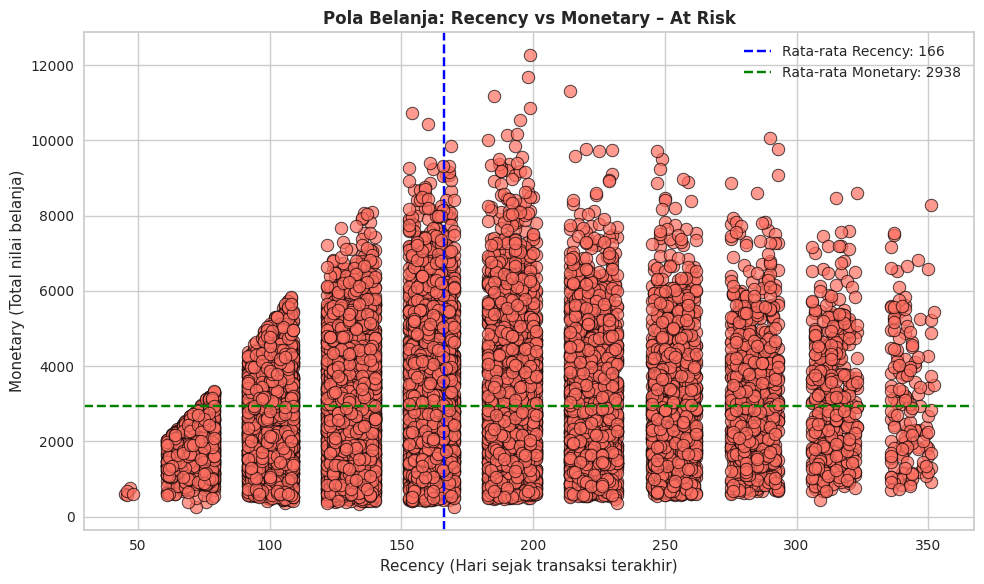

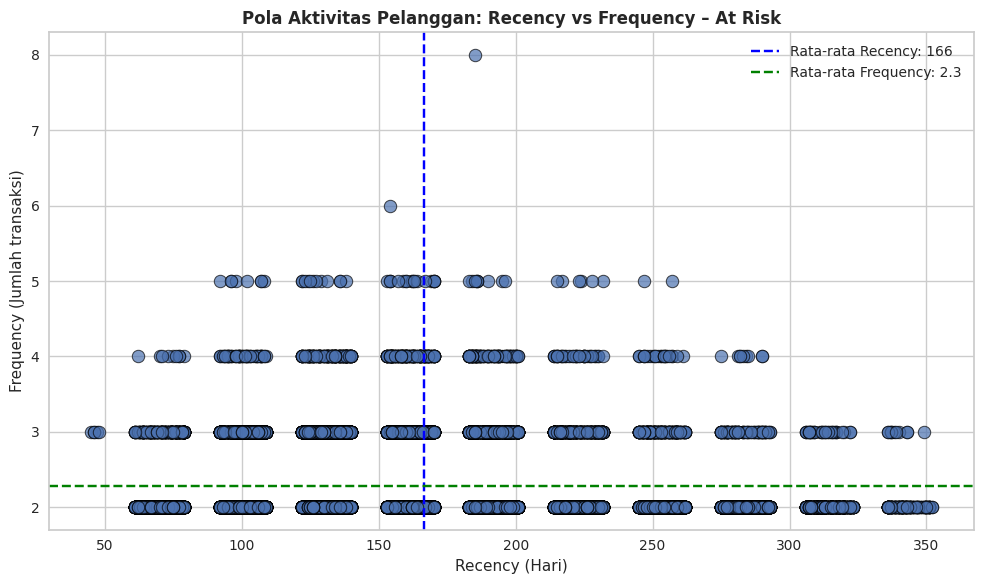

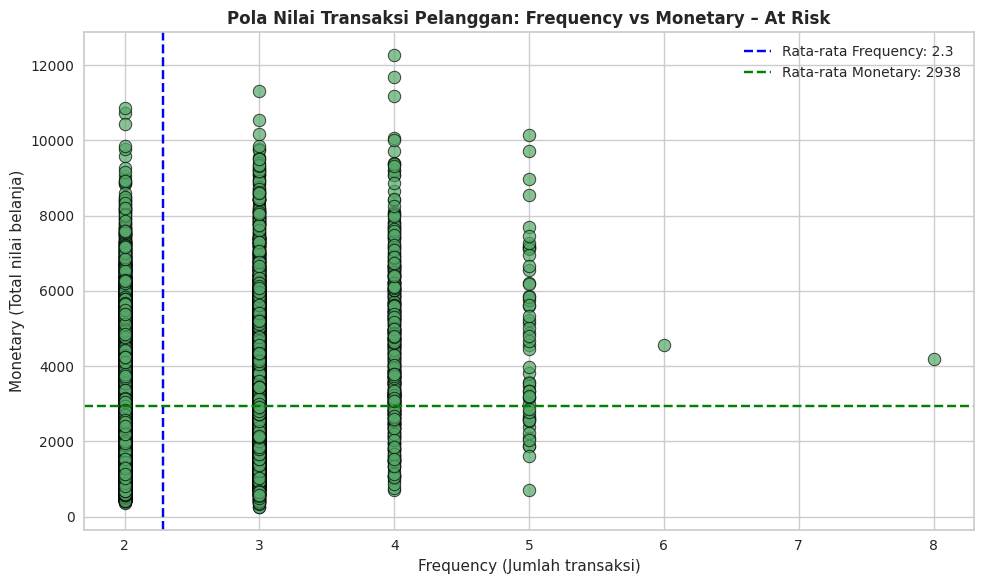


>>> VISUALISASI CLUSTER: HIBERNATING <<<


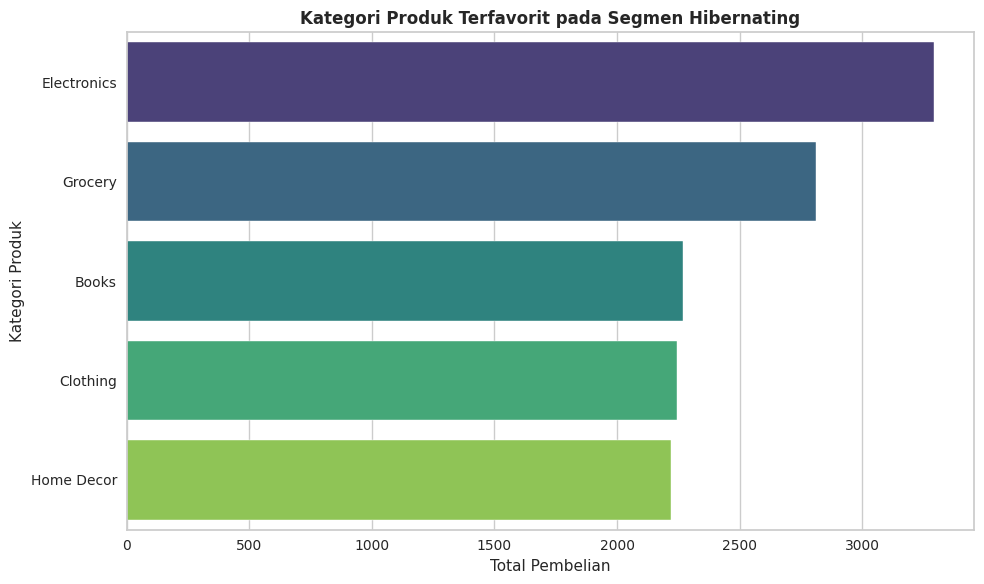

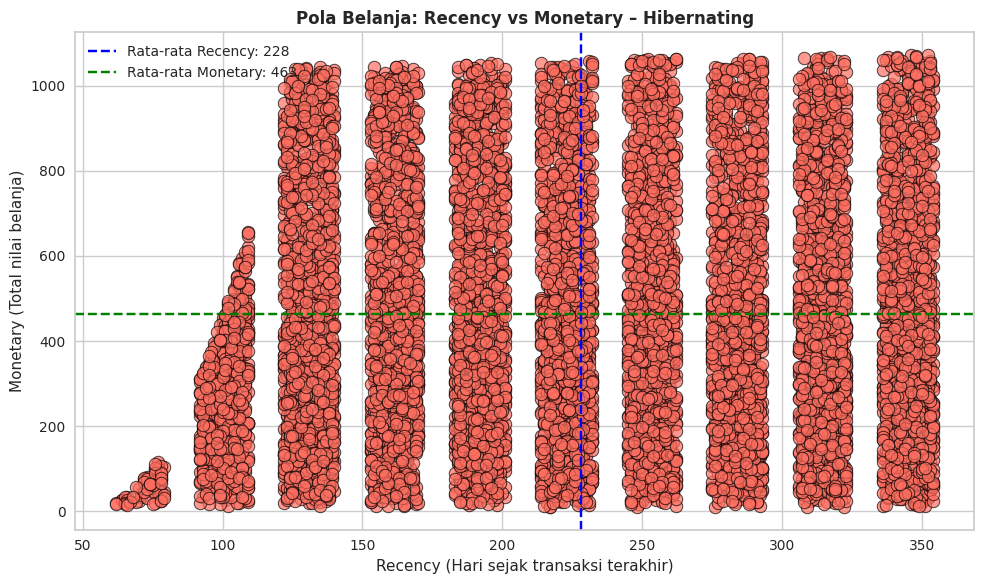

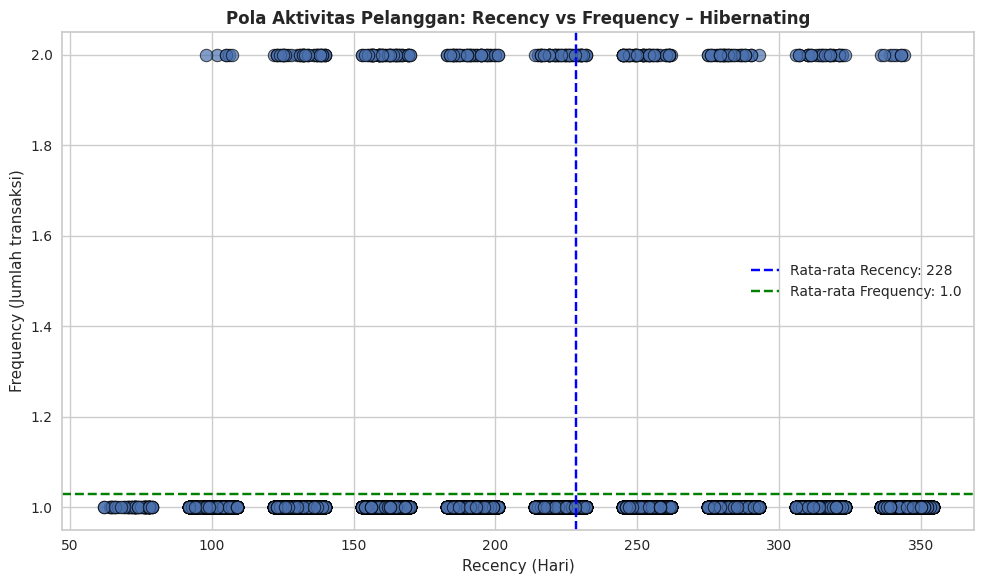

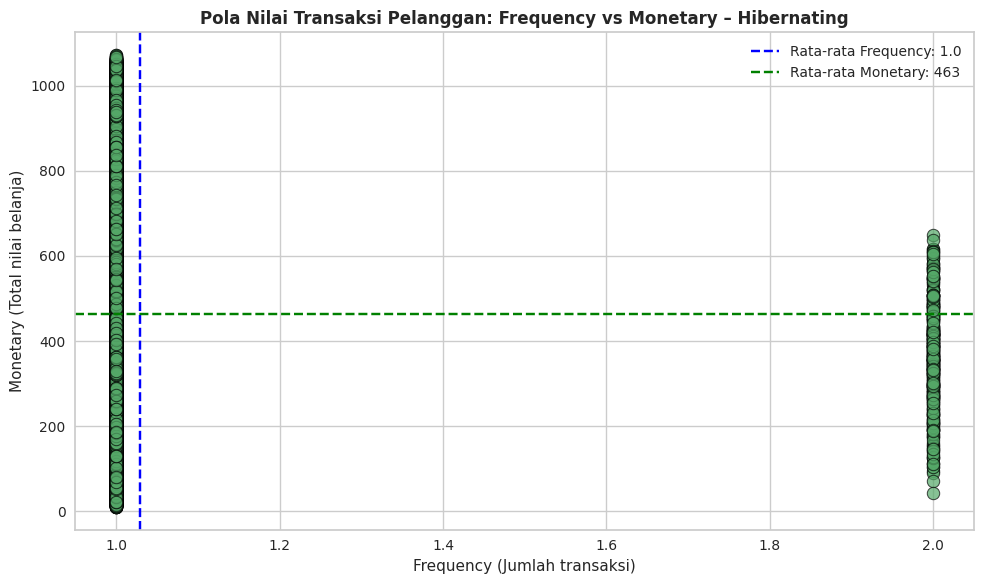

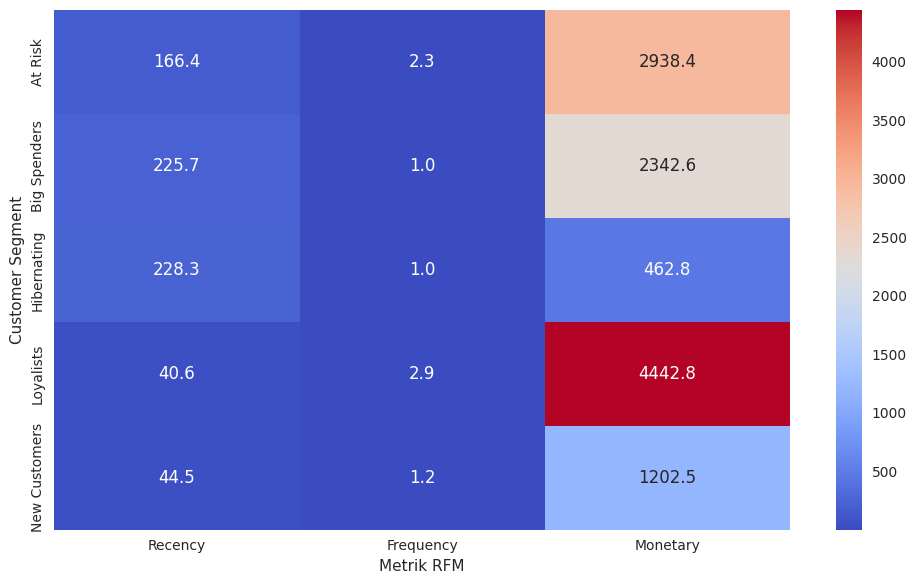

In [58]:
def visualisasi_terpisah_per_cluster_fixed(df_final, df_transaksi_asli):
    # ==============================
    # PERSIAPAN DATA
    # ==============================
    if 'customer_id' not in df_final.columns:
        df_final = df_final.reset_index()

    df_lengkap = df_transaksi_asli.merge(
        df_final[['customer_id', 'Customer_Segment']],
        on='customer_id',
        how='left'
    )

    urutan_segmen = ['Loyalists', 'Big Spenders', 'New Customers', 'At Risk', 'Hibernating']
    segmen_tersedia = [s for s in urutan_segmen if s in df_final['Customer_Segment'].unique()]

    sns.set_style("whitegrid")

    # ==============================
    # VISUALISASI PER CLUSTER
    # ==============================
    for segmen in segmen_tersedia:
        data_produk = df_lengkap[df_lengkap['Customer_Segment'] == segmen]
        data_rfm = df_final[df_final['Customer_Segment'] == segmen]

        print("\n" + "="*80)
        print(f">>> VISUALISASI CLUSTER: {segmen.upper()} <<<")
        print("="*80)

        # -------------------------------------------------
        # 1️⃣ TOP 5 KATEGORI PRODUK (VIRIDIS)
        # -------------------------------------------------
        plt.figure(figsize=(10, 6))
        col_prod = 'product_category' if 'product_category' in data_produk.columns else 'Product_Category'
        if col_prod in data_produk.columns:
            top_cat = data_produk[col_prod].value_counts().head(5).reset_index()
            top_cat.columns = [col_prod, 'Total_Pembelian']
            sns.barplot(
                data=top_cat,
                x='Total_Pembelian',
                y=col_prod,
                hue=col_prod,          # ✅ FIX: assign hue
                palette='viridis',
                legend=False           # ✅ FIX: matikan legend
            )
            plt.title(f'Kategori Produk Terfavorit pada Segmen {segmen}', fontweight='bold')
            plt.xlabel('Total Pembelian')
            plt.ylabel('Kategori Produk')
        plt.tight_layout()
        plt.show()

        # -------------------------------------------------
        # 2️⃣ POLA BELANJA: RECENCY vs MONETARY
        # -------------------------------------------------
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=data_rfm,
            x='Recency',
            y='Monetary',
            color='#FF6F61',
            s=80,
            alpha=0.7,
            edgecolor='black'
        )

        avg_r = data_rfm['Recency'].mean()
        avg_m = data_rfm['Monetary'].mean()
        plt.axvline(avg_r, color='blue', linestyle='--', label=f'Rata-rata Recency: {avg_r:.0f}')
        plt.axhline(avg_m, color='green', linestyle='--', label=f'Rata-rata Monetary: {avg_m:.0f}')

        plt.title(f'Pola Belanja: Recency vs Monetary – {segmen}', fontweight='bold')
        plt.xlabel('Recency (Hari sejak transaksi terakhir)')
        plt.ylabel('Monetary (Total nilai belanja)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # -------------------------------------------------
        # 3️⃣ POLA AKTIVITAS PELANGGAN: RECENCY vs FREQUENCY
        # -------------------------------------------------
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=data_rfm,
            x='Recency',
            y='Frequency',
            color='#4C72B0',   # Biru lembut
            s=80,
            alpha=0.7,
            edgecolor='black'
        )

        avg_f = data_rfm['Frequency'].mean()
        plt.axvline(avg_r, color='blue', linestyle='--', label=f'Rata-rata Recency: {avg_r:.0f}')
        plt.axhline(avg_f.mean(), color='green', linestyle='--', label=f'Rata-rata Frequency: {avg_f:.1f}')

        plt.title(f'Pola Aktivitas Pelanggan: Recency vs Frequency – {segmen}', fontweight='bold')
        plt.xlabel('Recency (Hari)')
        plt.ylabel('Frequency (Jumlah transaksi)')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # -------------------------------------------------
        # 4️⃣ POLA NILAI TRANSAKSI PELANGGAN: FREQUENCY vs MONETARY
        # -------------------------------------------------
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            data=data_rfm,
            x='Frequency',
            y='Monetary',
            color='#55A868',   # Hijau
            s=80,
            alpha=0.7,
            edgecolor='black'
        )

        plt.axvline(avg_f, color='blue', linestyle='--', label=f'Rata-rata Frequency: {avg_f:.1f}')
        plt.axhline(avg_m, color='green', linestyle='--', label=f'Rata-rata Monetary: {avg_m:.0f}')

        plt.title(f'Pola Nilai Transaksi Pelanggan: Frequency vs Monetary – {segmen}', fontweight='bold')
        plt.xlabel('Frequency (Jumlah transaksi)')
        plt.ylabel('Monetary (Total nilai belanja)')
        plt.legend()

        plt.tight_layout()
        plt.show()

    # ==============================
    # 5️⃣ HEATMAP RFM (COOLWARM)
    # ==============================
    plt.figure(figsize=(10, 6))
    rfm_mean = df_final.groupby('Customer_Segment')[['Recency', 'Frequency', 'Monetary']].mean()

    sns.heatmap(rfm_mean, annot=True, fmt='.1f', cmap='coolwarm')
    plt.xlabel('Metrik RFM')
    plt.ylabel('Customer Segment')

    plt.tight_layout()
    plt.show()

visualisasi_terpisah_per_cluster_fixed(df_final, df)

In [59]:
df_final.columns.tolist()

['customer_id',
 'order_status',
 'age',
 'gender',
 'income',
 'product_category',
 'products',
 'payment_method',
 'quantity',
 'unit_price',
 'Recency',
 'Frequency',
 'Monetary',
 'Cluster',
 'Customer_Segment',
 'PC1 (Principal Component 1)',
 'PC2 (Principal Component 2)']

In [60]:
rfm_summary = df_final.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().reset_index()

# 3. Menambahkan kolom jumlah user per cluster (Opsional tapi sangat berguna)
rfm_summary['Count'] = df_final.groupby('Cluster')['customer_id'].count().values

# 4. Membulatkan angka agar tabel mudah dibaca
rfm_summary = rfm_summary.round(2)

print("Tabel Rata-rata RFM per Cluster:")
display(rfm_summary)

Tabel Rata-rata RFM per Cluster:


Cluster  Recency  Frequency  Monetary  Count
0      0.0   166.37       2.28   2938.45  16241
1      1.0   228.29       1.03    462.78  11595
2      2.0    40.61       2.87   4442.76  15101
3      3.0    44.50       1.17   1202.52  10555
4      4.0   225.75       1.00   2342.64  11729

In [46]:
pip install pipreqs

In [47]:
code_content = ""
for cell in _ih:
    clean_lines = []
    for line in cell.split('\n'):
        # Filter perintah magic agar tidak error saat dibaca pipreqs
        if not line.strip().startswith(('!', '%', 'pip', 'apt')):
            clean_lines.append(line)
    code_content += "\n".join(clean_lines) + "\n"

# --- Langkah 2: Buat file .py sementara ---
with open("temp_script.py", "w", encoding="utf-8") as f:
    f.write(code_content)

# --- Langkah 3: Jalankan pipreqs pada file tersebut ---
print("Sedang mendeteksi library...")
# Kita targetkan folder saat ini (.) tapi pipreqs akan menemukan temp_script.py
!pipreqs . --force --savepath requirements.txt

# --- Tampilkan Hasil ---
print("\n--- Isi requirements.txt ---")
!cat requirements.txt

# (Opsional) Hapus file sementara
if os.path.exists("temp_script.py"):
    os.remove("temp_script.py")

Sedang mendeteksi library...
INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in requirements.txt

--- Isi requirements.txt ---
kneed==0.8.5
matplotlib==3.10.8
nump